<a href="https://colab.research.google.com/github/OmkarKotwalProject/Dominos_Work/blob/main/Dominos_Work_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import nltk
import re
import gensim
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
import sklearn.metrics as sm
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [5]:
!pip install pyspellchecker
!pip install Counter

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

     |████████████████████████████████| 2.7 MB 5.2 MB/s 
  Created wheel for Counter: filename=Counter-1.0.0-py3-none-any.whl size=5411 sha256=1788483049a1c1b6622b0868ac761690c075b4b0e889579de5c0b2e5f4e12cbb
  Stored in directory: /root/.cache/pip/wheels/f9/15/75/7a0462a00beb08e391f5da370ca409b56781d2501dba083fa3
Successfully built Counter
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",None)
pd.set_option("display.max_colwidth",None)

In [7]:
from google.colab import drive
drive.mount('/content/drive/')



Mounted at /content/drive/


In [8]:
cd /content/drive/MyDrive/CUSTOMER_REVIEWS/ScrapedReviews/PROJECT SCRAPED REVIEWS/Dominos Pizza 3k/

/content/drive/MyDrive/CUSTOMER_REVIEWS/ScrapedReviews/PROJECT SCRAPED REVIEWS/Dominos Pizza 3k


In [9]:
df = pd.read_excel('All_Reviews_DP.xlsx')

In [10]:
# import matplotlib.pyplot as plt
# import pandas as pd
# from google.colab import files
# import io


# uploaded = files.upload()
# df= pd.read_excel(io.BytesIO(uploaded['All_Reviews_DP.xlsx']))

In [11]:
#Keeping the original as it is.
df_review=df 

THIS IS A BACKUP LOAD OF ORIGINAL DATAFRAME, ONLY USE IF MESSED UP

In [12]:
# #FOR EMPTYING THE DATAFRAME
# df_review.drop(columns=['Review','Sentiment'],inplace=True)

In [13]:
# #FOR RELOADING WITH ORIGINAL RAW DATA
# df= pd.read_excel(io.BytesIO(uploaded['All_Reviews_DP.xlsx']))
# df_review=df

BACKUP CODE END

In [14]:
df_review['Sentiment']=df_review['Sentiment'].astype(int)

In [15]:
print(df_review.head())
print(df_review.shape)

                                                                                                                                                                                                                                                              Review  \
0                                                                                                                                                                                                                                                       its too good   
1                                                                                                                                                                                                                                                     waste of money   
2                                                                                                                                                                                                               

HOW MANY POSITIVE REVIEWS, HOW MANY NEGATIVE REVIEWS

In [16]:
print(df_review[df_review['Sentiment']==1].count())
print(df_review[df_review['Sentiment']==0].count())

Review       1543
Sentiment    1543
dtype: int64
Review       1203
Sentiment    1203
dtype: int64


In [17]:
df_review['Sentiment'].unique()

array([1, 0])

In [18]:
#Checking if any null values
df_review[df_review.isna().any(axis=1)]

,Review,Sentiment


PRE-PROCESSING!

1.^[\w\s]=remove all except alphanumeric and whitespaces tabs and spaces [\d] remove digits

In [19]:
df['Review']=df['Review'].replace('\d+','',regex=True)

<input>:1: DeprecationWarning: invalid escape sequence \d
<ipython-input-19-7140ae72fba7>:1: DeprecationWarning: invalid escape sequence \d
  df['Review']=df['Review'].replace('\d+','',regex=True)


2.WHAT AM I TRYING TO DO HERE:- Removing more than 2 consecutive occurrences of a character, if its a special char, replace with space
so @@@@@@ => @@ and then '__'. This will happen with words too, hellllloo => helloo

In [ ]:
#WHAT AM I TRYING TO DO HERE:-  Removing more than 2 consecutive occurrences of a character, if its a special char, replace with space
# so @@@@@@ => @@ and then '__'. This will happen with words too, hellllloo => helloo
#1. REPLACE SPECIAL CHARACTERS BY ' ' AND then using regex, remove consecutive duplicates of ' ' i.e '         '  (big spaces between words)
df_review['Review']=df_review['Review'].replace('\n', ' ',regex=True)
df_review['Review']=df_review['Review'].replace(('[^!|^.|^,|^;|^-|^@|^\w\s]'),"", regex = True)
for i in range(len(df_review)):
  sentence=df_review['Review'][i]
  sentence=sentence.replace('.', ' ')
  sentence=sentence.replace(',', ' ')
  sentence=sentence.replace('!', ' ')
  sentence=sentence.replace('.', ' ')
  sentence=sentence.replace(';', ' ')
  sentence=sentence.replace('-', ' ')
  sentence=sentence.replace('@', ' ')
  sentence=sentence.replace(')', ' ')
  sentence=sentence.replace('(', ' ')
  sentence=sentence.replace('{', ' ')
  sentence=sentence.replace('}', ' ')

  sentence=re.sub(r'(.)\1+', r'\1\1',sentence)   # yummmyyy => yummyy,  '     '=>'  '  #This line will remove char which occures more than 2 times consecutively.
  df_review['Review'][i]=sentence

#df_review['Review']=df_review['Review'].replace('[^\w\s]', '',regex=True)
print(df_review.head(10))

3.REMOVING CHARACTERS WHICH ONLY OCCUR ONCE! ALSO REPLACING TWO CONSECUTIVE SPACES BY ONE

In [ ]:
cnter=0
while(cnter<2):
  for i in range(len(df_review)):
    new_sentence=" "
    sentence=df_review['Review'][i]    #get the row i.e. sentence
    #print("before removing:",df_review['Review'][i])
    words=sentence.split()  #makes a list of the words in the sentence
    for word in words:      #check every words length and if it is less than 2, remove it
      if len(word)<2:
        #print(word)
        words.remove(word)
    new_sentence=new_sentence.join(words) #Create a new sentence by joining all the words in the list with " " as a separator
    df_review['Review'][i]=new_sentence   #replace current row i.e. sentence by the new sentence
    #print("after removing:",df_review['Review'][i])
  cnter=cnter+1

In [22]:
#printing word if length is less than 2
for i in range(len(df_review)):
  sentence=df_review['Review'][i]
  words=sentence.split()  #makes a list of the words in the sentence
  for word in words:      #check every words length and if it is less than 2, print it
    if len(word)<2:
      print(word)

In [23]:
print(df_review.head(5))

                                                                                                                                                                                                                                                              Review  \
0                                                                                                                                                                                                                                                       its too good   
1                                                                                                                                                                                                                                                     waste of money   
2                                                                                                                                                                                                               

4.FINDING MISSPELLED WORDS AND CORRECTING THEM!
Algorithm used for correcting words:

    Create a list of misspelled words found in the dataset.
    Create a list of correctly spelled words found in the dataset.
    Use similar() function of 'SequenceMatcher' for finding similarity between words from both lists. If it is greater than 0.8, create a dictionary (dict['misspelled word'=correctly spelled word).
    Now traverse the dataset, while checking a row, extract its misspelled words, check if misspelled word is in the dictionary, if it is then replace it with correctly spelled word.

In [ ]:
#This creates a list of sets of misspelled words found in each row.
from spellchecker import SpellChecker
spell=SpellChecker()
mis_list=[]
for i in range(len(df_review)):
  sentence=df_review['Review'][i].split()
  mis_sent=spell.unknown(sentence)
  mis_list.append(mis_sent)
  if set() in mis_list:
    mis_list.remove(set())
print("first 50 row's Misspelled words but they are in [{misspelled words list from row 1},{misspelled words list from row 2}]: ",mis_list[0:50])

In [ ]:
#Creating a list of misspelled words. (Basically extracting each set element from the mis_list and putting it into mis_mis_list)

from collections import Counter
mis_mis_list=[]
for i in mis_list:
  for j in i:
    mis_mis_list.append(j.lower())   #just making the words lower before appending to mis_mis_list


#cnt=0
#for i in mis_mis_list:        #removing 'rs', 'mr', 'ms' from the list as they aren't misspelled words in a way.
  # if i=='rs':
  #   #cnt=cnt+1
  #   mis_mis_list.remove(i)
  # if i=='mr':
  #   mis_mis_list.remove(i)
  # if i=='ms':
  #   mis_mis_list.remove(i)    
print("first 50 Misspelled words:",mis_mis_list[0:50]) #LIST OF MISSPELLED WORDS   
print("Total misspelled words: ",len(mis_mis_list)) #Note: this list is not a 'unique mispelled words' list, it has repeated occurences of them.


#Finding common words and their occurrences in the mis_mis_list #Just a trial code for common words finder.
cnt=Counter(mis_mis_list)
cmmn=cnt.most_common(100)   
print(cmmn)

In [ ]:
#REMOVING NAMES FROM THE LIST of misspelled words
names_list=['zomato','pm','rs','aundh','nonveg','mexicana','hr','kandivali','chocolava','nigdi',
            'cheeseburst','bbq','saudagar','zingy','makhani','paneer','periperi','tandoor']
for name in names_list:
  for j in range(len(mis_mis_list)):
    if name in mis_mis_list:
      mis_mis_list.remove(name)
print("Final Misspelled words list after removing names: (Showing only first 50) ",mis_mis_list[0:50]) #This is the list of misseplled words!



#Trial code for common words finder, again.
cnt=Counter(mis_mis_list)
cmmn=cnt.most_common(100)   #Finding common words and their occurrences in the mis_mis_list     
print(cmmn)    

Finding a list of correctly spelled words!

In [ ]:
#first, just creating a list of words found in the dataset
correct_word_list=[]
for i in range(len(df_review)):
  sentence=df_review['Review'][i]
  words=sentence.split()
  for word in words:
    correct_word_list.append(word.lower())
print(correct_word_list[0:50])


In [28]:
#We have to make both lists mis_mis_list and correct_words_list contain unique words, not repeated words or 'remove' won't work!
print("total of all words of misspelled word list:",len(mis_mis_list))
print("total of all words of correct word list+misspelled word list:",len(correct_word_list))
mis_mis_list=list(set(mis_mis_list))
correct_word_list=list(set(correct_word_list))
print("total of unique words of misspelled word list:",len(mis_mis_list))
print("total of unique words of correct word list+missplled word list:",len(correct_word_list))
print("total of unique words of names list:",len(names_list))

total of all words of misspelled word list: 761
total of all words of correct word list+misspelled word list: 60164
total of unique words of misspelled word list: 536
total of unique words of correct word list+missplled word list: 4136
total of unique words of names list: 18


In [29]:
names_list=['zomato','pm','rs','aundh','nonveg','mexicana','hr','kandivali','chocolava','nigdi',
            'cheeseburst','bbq','saudagar','zingy','makhani','paneer','periperi','tandoor']
cnt=0
#Removing misspelled words from correct_word_list, found in mis_mis_list
for w in mis_mis_list:
  if w in correct_word_list:
    correct_word_list.remove(w)

#Removing names from correct_word_list, found in names_list
for n in names_list:
  if n in correct_word_list:
    correct_word_list.remove(n) 
print("correct word list length after removing misspelled words and names:",len(correct_word_list))

correct word list length after removing misspelled words and names: 3582


In [30]:
#The only misspelled words in word_list

mis_words=spell.unknown(correct_word_list)
print(mis_words)

set()


In [31]:
#Checking similarity between words from correct_word_list and mis_mis_list, if its more than 0.8, 
#do dictionary[misspelled word]=correct word
#TAKES 1 MINUTE+
from difflib import SequenceMatcher       #Library used for checking similarity

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()    #Function to check similarity!

dictionary={}
cnt=0
for cor_word in correct_word_list:
  for mis_word in mis_mis_list:
    ratio=similar(cor_word,mis_word)
    if(ratio>0.8):
      cnt=cnt+1
      dictionary[mis_word]=cor_word
      #print("Correct word:",cor_word,"    misspelled word:",mis_word,"      Ratio:",ratio)
print("This many words can be corrected: ",cnt)

This many words can be corrected:  355


In [ ]:
#Replacing the misspelled words with correct words
#Takes almost 10 seconds
words_corrected_cnt=0
for i in range(len(df_review)):
  sentence=(df_review['Review'][i]).lower()
  print("before:",sentence)
  misspelled_words=spell.unknown(sentence.split())
  print("list:",misspelled_words)
  for misword in misspelled_words:
    if misword in dictionary:
      correct_word=dictionary[misword]
      print("misspelled word: ",misword,"     ","correct word:",correct_word)
      sentence=sentence.replace(misword,correct_word)
      words_corrected_cnt=words_corrected_cnt+1
  df_review['Review'][i]=sentence
  print("After:",sentence)

In [33]:
#This many words were corrected and replaced
print(words_corrected_cnt)

342


5. Removing stopwords

In [34]:
print(df_review['Review'].head())

0                                                                                                                                                                                                                                                         its too good
1                                                                                                                                                                                                                                                       waste of money
2                                                                                                                                                                                                                                        pizza was yum but little late
3                                                                                                                                                                                                                  

In [35]:
from nltk.corpus import stopwords
sw=stopwords.words("english")
print(sw)
#Removing the words below from the stopword list as they do impact the outcome when doing sentiment analysis. 
sw.append('would')
words=['no','not']
sw.remove('not')
sw.remove('no')
#sw.remove('never')
sw.remove('don\'t')
sw.remove('didn\'t')
sw.remove('wouldn\'t')
sw.remove('wouldn')
sw.remove('won\'t')
sw.remove('didn')
sw.remove('don')
sw.remove('isn\'t')
sw.remove('isn')
#sw.remove('can\'t')
sw.remove('couldn\'t')
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Making 'Review' lower so I can remove stopwords

In [36]:
df_review['Review']=df_review['Review'].str.lower()

In [37]:
df_review['Review']=df_review['Review'].apply(lambda x:" ".join(x for x in str(x).split() if x not in sw))
print(df_review.head())

                                                                                                                                                                                           Review  \
0                                                                                                                                                                                            good   
1                                                                                                                                                                                     waste money   
2                                                                                                                                                                           pizza yum little late   
3                                                                                                                                                                         delivery person amazing   
4  even calling

In [38]:
#TOTAL WORDS AFTER REMOVING STOP WORDS!
p_list=[]
for i in range(len(df_review)):
  ent=df_review['Review'][i].split()
  p_list.append(ent)

word_list=[]
for element in p_list:
  for word in element:
    word_list.append(word)
print(len(word_list))

35989


6. Tokenization

In [39]:
#Tokenization done to apply Lemmatization
w_tokenizer=nltk.tokenize.WhitespaceTokenizer()
lemmatizer=nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
  return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]

df_review['Review']=df_review.Review.apply(lemmatize_text)
print(df_review.head())

                                                                                                                                                                                                          Review  \
0                                                                                                                                                                                                         [good]   
1                                                                                                                                                                                                 [waste, money]   
2                                                                                                                                                                                     [pizza, yum, little, late]   
3                                                                                                                                                       

From tokenized to normal

In [40]:
df_review['NewReview'] = df_review['Review'].apply(lambda s1: ' '.join(map(str,s1)) )

print(df_review['NewReview'].head())

0                                                                                                                                                                                  good
1                                                                                                                                                                           waste money
2                                                                                                                                                                 pizza yum little late
3                                                                                                                                                                 delivery person amaze
4    even call personally even give special instructions receive cold pizza base hard taste stale premade think chicken parcel really hot fresh proper quantity really disappoint pizza
Name: NewReview, dtype: object


In [41]:
df_review['NewReview']=df_review['NewReview'].str.lower()
df_review.head()

,Review,Sentiment,NewReview
0,[good],1,good
1,"[waste, money]",0,waste money
2,"[pizza, yum, little, late]",1,pizza yum little late
3,"[delivery, person, amaze]",1,delivery person amaze
4,"[even, call, personally, even, give, special, instructions, receive, cold, pizza, base, hard, taste, stale, premade, think, chicken, parcel, really, hot, fresh, proper, quantity, really, disappoint, pizza]",0,even call personally even give special instructions receive cold pizza base hard taste stale premade think chicken parcel really hot fresh proper quantity really disappoint pizza


# Sentiment Analysis

In [42]:
print("The number of samples in the dataset!")
pos_percent=(len(df_review[df_review['Sentiment']==1])/len(df_review)*100)
print("Positive reviews percentage: ",round(pos_percent,2),"%")
neg_percent=(len(df_review[df_review['Sentiment']==0])/len(df_review)*100)
print("Negative reviews percentage: ",round(neg_percent,2),"%")
print("Positive reviews: ",len(df_review[df_review['Sentiment']==1]))
print("Negative reviews: ",len(df_review[df_review['Sentiment']==0]))

The number of samples in the dataset!
Positive reviews percentage:  56.19 %
Negative reviews percentage:  43.81 %
Positive reviews:  1543
Negative reviews:  1203


Train-test split starts here!

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
train_data,test_data=train_test_split(df_review,test_size=0.2,random_state=50)  #keep random_state=50 for higher precision and recall of 0 class when using SVM
#train_data,test_data=train_test_split(new_df_review,test_size=0.4,random_state=25)

In [45]:
print(df_review.shape)
print('test_data(Positive):',test_data[test_data['Sentiment']==1].count())
print('test_data(Negative):',test_data[test_data['Sentiment']==0].count())

print("train_data (Positive):",train_data[train_data['Sentiment']==1].count())
print('train_data (Negative):',train_data[train_data['Sentiment']==0].count())

(2746, 3)
test_data(Positive): Review       311
Sentiment    311
NewReview    311
dtype: int64
test_data(Negative): Review       239
Sentiment    239
NewReview    239
dtype: int64
train_data (Positive): Review       1232
Sentiment    1232
NewReview    1232
dtype: int64
train_data (Negative): Review       964
Sentiment    964
NewReview    964
dtype: int64


In [46]:
X_train=train_data['NewReview']
y_train=train_data['Sentiment']
X_test=test_data['NewReview']
y_test=test_data['Sentiment']

In [47]:
#Checking if any null values
train_data[train_data.isna().any(axis=1)]

,Review,Sentiment,NewReview


In [48]:
print(X_train.head())
print(X_test.head())

17                                                                                                                                                                                                                      delivery charge high even zomato pro members around rs dominos outlet literally next door house
1263                                                                                                                                              domino domino outlet locate thakur college thakur village domino time favourite ambience outdoor indoor staff friendly pizza tasty yummy think one best outlet domino
473     dominos best place crave pizza like domino pizza hut cheese burst die soo freak cheesy new addition menu burger pizza look like burger taste like pizza try burger pizza today superb soo cheesy hot soft lot veggies chicken piece new favourite guy wait goo hog youll definitely love cant miss piece heaven
2496                                                            

7. Vectorizer

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
train_vectorizer=TfidfVectorizer(use_idf=True,lowercase=True,strip_accents='ascii')
train_review_tfidf=train_vectorizer.fit_transform(X_train)

In [51]:
print(train_review_tfidf.shape)
type(train_review_tfidf)

(2196, 2787)


scipy.sparse.csr.csr_matrix

In [52]:
df_review['Sentiment'].unique()
df_review[df_review['Sentiment']=='.']

,Review,Sentiment,NewReview


a. LOGISTIC REGRESSION

In [ ]:
log_model=LogisticRegression().fit(train_review_tfidf, y_train)

In [ ]:
cross_val_score(log_model,train_review_tfidf,y_train,scoring='accuracy',cv=5).mean()

In [55]:
#USE THIS WHEN TESTING ON SPLIT TEST DATA
nr=train_vectorizer.transform(X_test)
log_model.predict(nr)

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,

In [56]:
predicted=log_model.predict(nr)
p=pd.DataFrame(predicted)
actual=y_test

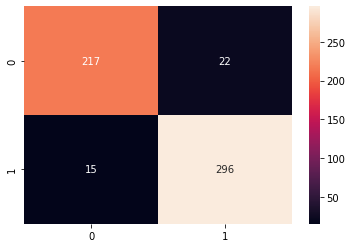

In [57]:
import seaborn as sns
cf_matrix=sm.confusion_matrix(actual,p)
sns.heatmap(cf_matrix,annot=True,fmt='g')

In [58]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       239
           1       0.93      0.95      0.94       311

    accuracy                           0.93       550
   macro avg       0.93      0.93      0.93       550
weighted avg       0.93      0.93      0.93       550



b. SVM

In [59]:
from sklearn.svm import SVC
svclassifier=SVC(kernel='rbf',C=10,gamma=1)
svclassifier.fit(train_review_tfidf,y_train)

SVC(C=10, gamma=1)

In [60]:
nr=train_vectorizer.transform(X_test)
svclassifier.predict(nr)

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,

In [61]:
predicted=svclassifier.predict(nr)
p=pd.DataFrame(predicted)
actual=y_test

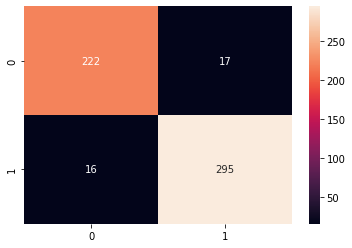

In [62]:
cf_matrix=sm.confusion_matrix(actual,p)
sns.heatmap(cf_matrix,annot=True,fmt='g')

In [63]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       239
           1       0.95      0.95      0.95       311

    accuracy                           0.94       550
   macro avg       0.94      0.94      0.94       550
weighted avg       0.94      0.94      0.94       550



# LDA

#kmeans trial

In [64]:
# from sklearn.cluster import KMeans
# def cluster_texts(num_clusters,tfidf):
#   print('Beginning KMeans Clustering, number of clusters=',num_clusters,'\n')
#   km=KMeans(n_clusters=num_clusters,max_iter=100,verbose=2,n_init=1).fit(tfidf)
#   return km

In [65]:
# nr_vectorized_neg_reviews=train_vectorizer.transform(df_review[df_review['Sentiment']==0].NewReview)

In [66]:
# n=25
# kmeans12=cluster_texts(n,nr_vectorized_neg_reviews)

In [67]:
# kmeans_df=pd.DataFrame()
# kmeans_df['assigned_labels']=kmeans12.labels_
# kmeans_df['reviews']=df_review[df_review['Sentiment']==0].NewReview

In [68]:
# kmeans_df['assigned_labels'].value_counts()

In [69]:
# for i in range(6):
#   print("Cluster ",i,":")
#   df_clustered=kmeans_df[kmeans_df['assigned_labels']==i]
#   print(df_clustered['reviews'])
#   print("\n\n")
  

#kmeans trial end

19/04/22

In [70]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [71]:
from nltk.corpus import stopwords
sw=stopwords.words('english')
print(sw)
sw.append('didnt')
sw.append('hadnt')
sw.append('wont')
sw.append('couldnt')
sw.append('dont')
sw.append('good')
sw.append('havent')
#trial=pd.DataFrame()
df_review['NewReview']=df_review['NewReview'].apply(lambda x:" ".join(x for x in str(x).split() if x not in sw))
# trial['Review']=df_review['Review'].apply(lambda x:' '.join(x for x in str(x).split() if x not in sw))
# trial['Sentiment']=df_review['Sentiment']

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [72]:
from nltk import word_tokenize, pos_tag

def nouns(text):
  '''extract nouns only from given string'''
  #is_noun=lambda pos:pos[:2] == 'NN' or pos[:2] == 'JJ'
  is_noun=lambda pos:pos[:2] == 'JJ' or pos[:2] == 'JJR' or pos[:2] == 'RBR' 
  tokenized=word_tokenize(text)
  all_nouns=[word for (word,pos) in pos_tag(tokenized) if is_noun(pos)]
  return ' '.join(all_nouns)

In [73]:
data_nouns=pd.DataFrame(df_review[df_review['Sentiment']==0].NewReview) #.apply(nouns))

In [74]:
data_nouns=data_nouns.reset_index()

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english', max_df=.1, max_features=2000)
X = count.fit_transform(data_nouns.NewReview) #feature matrix

In [76]:
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer(analyzer='word',       
#                              min_df=10,                        # minimum reqd occurences of a word 
#                              stop_words='english',             # remove stop words
#                              lowercase=True,                   # convert all words to lowercase
#                              token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
#                              # max_features=50000,             # max number of uniq words
#                             )
#vectorizer=CountVectorizer()
num_components=10

lda=LatentDirichletAllocation(n_components=num_components,max_iter=100)

#nr_vectorized_neg_reviews=train_vectorizer.transform(df_review[df_review['Sentiment']==0].NewReview)
nr_vectorized_neg_reviews=train_vectorizer.transform(data_nouns.NewReview)

lda_matrix=lda.fit_transform(nr_vectorized_neg_reviews)

lda_model_components=lda.components_

In [77]:
print(lda_matrix.shape)

(1203, 10)


In [78]:
#printing the topics with their terms
terms=train_vectorizer.get_feature_names()

for index, component in enumerate(lda_model_components):
  zipped=zip(terms,component)
  top_terms_key=sorted(zipped, key=lambda t:t[1], reverse=True)[:10]
  top_terms_list=list(dict(top_terms_key).keys())
  print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['salty', 'satisfactory', 'prepare', 'cheeseburst', 'low', 'directly', 'pepperoni', 'thing', 'wasnt', 'properly']
Topic 1:  ['miss', 'average', 'items', 'properly', 'seal', 'reason', 'peri', 'box', 'follow', 'hurry']
Topic 2:  ['cheese', 'less', 'pizza', 'burst', 'bread', 'oregano', 'order', 'garlic', 'toppings', 'flake']
Topic 3:  ['delay', 'bite', 'delivery', 'available', 'park', 'slow', 'unprofessional', 'inside', 'condition', 'rubbish']
Topic 4:  ['late', 'delivery', 'deliver', 'order', 'cold', 'pizza', 'receive', 'time', 'food', 'hour']
Topic 5:  ['pizza', 'order', 'cheese', 'taste', 'dominos', 'like', 'time', 'also', 'place', 'get']
Topic 6:  ['min', 'water', 'free', 'spend', 'nothing', 'drink', 'costly', 'stale', 'money', 'overcook']
Topic 7:  ['slow', 'clean', 'take', 'minutes', 'long', 'staff', 'short', 'estimate', 'weekend', 'return']
Topic 8:  ['order', 'worst', 'deliver', 'call', 'receive', 'wrong', 'zomato', 'refund', 'delivery', 'cancel']
Topic 9:  ['bad', 'pizz

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
!pip install pyLDAvis

In [80]:
train_vectorizer=TfidfVectorizer(use_idf=True,lowercase=True,strip_accents='ascii')
tfidf_=train_vectorizer.fit_transform(data_nouns.NewReview)
tf_vectorizer = CountVectorizer()
tf_ = tf_vectorizer.fit_transform(data_nouns.NewReview) #feature matrix

num_components=10
#for tf
lda=LatentDirichletAllocation(n_components=num_components,max_iter=100)
lda_tf=lda.fit(tf_)
#for tfidf
lda_tfidf=lda.fit(tfidf_)

In [81]:
#print(len(lda_tf.columns))
print(tf_.shape)

(1203, 2133)


In [82]:
#pyLDAvis for tf 
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tf,tf_,tf_vectorizer)
#pyLDAvis.save_html(lda,'topics_vis.html')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.253726 -0.058375       1        1  67.771858
0     -0.098499  0.118467       2        1   6.239204
7      0.016243 -0.071329       3        1   4.240495
9      0.080480 -0.013153       4        1   4.096185
4      0.049325 -0.001451       5        1   4.011703
3      0.045089 -0.035008       6        1   3.735990
6      0.033561 -0.021041       7        1   3.622340
1      0.053636 -0.006196       8        1   2.208904
5      0.020512  0.089413       9        1   2.147865
2      0.053378 -0.001325      10        1   1.925454, topic_info=          Term        Freq       Total Category  logprob  loglift
486   delivery  164.000000  164.000000  Default  30.0000  30.0000
1018      late  114.000000  114.000000  Default  29.0000  29.0000
484    deliver  172.000000  172.000000  Default  28.0000  28.0000
1291     order  315.000000  315.000000  Default  27.0000  27.0000
1900      time  156.000000  156.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
590     enough    1.185271   18.013150  Topic10  -5.5863   1.2289
1462  properly    1.359108   47.977011  Topic10  -5.4495   0.3861
1599        rs    0.849915    7.354927  Topic10  -5.9189   1.7920
1320   packets    0.785737    5.699114  Topic10  -5.9974   1.9686
1643    season    0.830080   23.618507  Topic10  -5.9425   0.6017

[527 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         8  0.417722        abide
9         3  0.207887   acceptable
9         5  0.415774   acceptable
11       10  0.386441  accommodate
12        8  0.420227       accord
...     ...       ...          ...
2121      7  0.125676          yet
2121      9  0.628381          yet
2124      4  0.628649        youre
2128      1  0.977397       zomato
2129      7  0.336363       zomota

[801 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 8, 10, 5, 4, 7, 2, 6, 3])

In [83]:
#pyLDAvis for tfidf 
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tfidf,tfidf_,train_vectorizer)
#pyLDAvis.save_html(lda,'topics_vis.html')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.253726 -0.058375       1        1  48.624780
0     -0.098499  0.118467       2        1   8.465994
7      0.016243 -0.071329       3        1   6.217631
6      0.033561 -0.021041       4        1   6.122645
9      0.080480 -0.013153       5        1   5.867971
4      0.049325 -0.001451       6        1   5.862001
3      0.045089 -0.035008       7        1   5.769752
5      0.020512  0.089413       8        1   4.725400
1      0.053636 -0.006196       9        1   4.375957
2      0.053378 -0.001325      10        1   3.967868, topic_info=          Term       Freq      Total Category  logprob  loglift
1018      late  35.000000  35.000000  Default  30.0000  30.0000
486   delivery  36.000000  36.000000  Default  29.0000  29.0000
484    deliver  33.000000  33.000000  Default  28.0000  28.0000
1291     order  54.000000  54.000000  Default  27.0000  27.0000
1900      time  28.000000  28.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
558        dry   0.490728   3.686535  Topic10  -5.6574   1.2104
1462  properly   0.604142   8.526214  Topic10  -5.4495   0.5799
1599        rs   0.377799   2.337937  Topic10  -5.9189   1.4043
1320   packets   0.349271   1.497568  Topic10  -5.9974   1.7712
1643    season   0.368982   4.134279  Topic10  -5.9425   0.8106

[511 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
9         6  0.649836      acceptable
15        4  0.995580             acs
21        1  0.385844         address
21        7  0.385844         address
26        9  0.948707       advertise
46        5  0.874375           along
48        1  0.908740            also
72        2  0.680820        anything
100       7  0.938703     arrangement
102       1  0.736241          arrive
102       5  0.368121          arrive
120       5  0.514221        attitude
131       4  0.843116    availability
133       1  0.694905         average
133      10  0.347453         average
145       1  0.516511             bad
145       2  0.086085             bad
145       3  0.301298             bad
145       4  0.043043             bad
145       9  0.043043             bad
147       2  0.622277             bag
158       3  0.669321            base
158       4  0.167330            base
158       5  0.167330            base
169       1  0.560373          become
169       8  0.560373          become
180       1  0.725113            best
180       5  0.362556            best
181       1  0.834754          better
192       1  0.561899            bite
192       4  0.374599            bite
210       7  0.558751          bottle
213       1  0.546431             box
213       4  0.273216             box
217       1  0.639617          branch
220       1  0.843206           bread
220       5  0.105401           bread
242       2  0.400936            burn
242       5  0.400936            burn
243       1  0.923761           burst
243       3  0.071059           burst
244       5  0.840108        business
245       4  0.578810            bust
248       6  0.647207             buy
250       1  0.672490            cake
250       6  0.336245            cake
251       1  0.962655            call
253       1  0.993127          cancel
259       7  0.695899        capsicum
284       5  0.375352          charge
284       7  0.375352          charge
286       3  0.650306            chat
289       9  0.778748           cheat
291       1  0.793994          cheese
291       3  0.158799          cheese
291       4  0.031760          cheese
292       5  0.637309     cheeseburst
294       5  0.617535           cheez
299       1  0.540978         chicken
299       3  0.135244         chicken
299       4  0.135244         chicken
299       6  0.135244         chicken
313       6  0.685157       chocolava
321       1  0.419656           cl

In [84]:
//

SyntaxError: ignored

19/04/22

###################

20/04/22

In [ ]:
bigram_measures=nltk.collocations.BigramAssocMeasures()

finder=nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in data_nouns.NewReview])

In [ ]:
finder.apply_freq_filter(5)
bigram_scores=finder.score_ngrams(bigram_measures.pmi)

In [ ]:
print(bigram_scores[10:30])

20/04/22

Tuning the LDA model!!!

Removing those stopwords which were included before!

In [ ]:
from nltk.corpus import stopwords
sw=stopwords.words('english')
print(sw)
sw.append('didnt')
sw.append('hadnt')
sw.append('wont')
sw.append('couldnt')
sw.append('dont')
sw.append('good')
#trial=pd.DataFrame()
df_review['NewReview']=df_review['NewReview'].apply(lambda x:" ".join(x for x in str(x).split() if x not in sw))
# trial['Review']=df_review['Review'].apply(lambda x:' '.join(x for x in str(x).split() if x not in sw))
# trial['Sentiment']=df_review['Sentiment']

In [ ]:
data_nouns.head()

In [ ]:
#Tokenization done to apply Lemmatization
w_tokenizer=nltk.tokenize.WhitespaceTokenizer()
lemmatizer=nltk.stem.WordNetLemmatizer()
d=pd.DataFrame()

def lemmatize_text(text):
  return [w for w in w_tokenizer.tokenize(text)]

d['TokenReviewLda']=data_nouns.NewReview.apply(lemmatize_text)
print(d.head())

In [ ]:
from gensim.corpora import Dictionary
dict_=Dictionary(d.TokenReviewLda)
print(dict_)

In [ ]:
doc_term_matrix=[dict_.doc2bow(i) for i in d.TokenReviewLda]
for i in doc_term_matrix:
  if i==[]:
    doc_term_matrix.remove(i)
print(doc_term_matrix)

In [ ]:
LdaModel=gensim.models.ldamodel.LdaModel
lda=LdaModel(doc_term_matrix,num_topics=10,id2word=dict_,passes=50,iterations=500)

In [ ]:
for tpc in lda.print_topics():
  print(tpc,"\n")

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer(analyzer='word',       
#                              min_df=10,                        # minimum reqd occurences of a word 
#                              stop_words='english',             # remove stop words
#                              lowercase=True,                   # convert all words to lowercase
#                              token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
#                              # max_features=50000,             # max number of uniq words
#                             )
#vectorizer=CountVectorizer()
num_components=4

lda=LatentDirichletAllocation(n_components=num_components)
train_vectorizer=TfidfVectorizer(use_idf=True,lowercase=True,strip_accents='ascii')

#train_vectorizer=CountVectorizer(lowercase=True,strip_accents='ascii')
nr_vectorized_neg_reviews=train_vectorizer.fit_transform(df_review[df_review['Sentiment']==0].NewReview)

lda_matrix=lda.fit_transform(nr_vectorized_neg_reviews)

lda_model_components=lda.components_

In [ ]:
#printing the topics with their terms
terms=train_vectorizer.get_feature_names()

for index, component in enumerate(lda_model_components):
  zipped=zip(terms,component)
  top_terms_key=sorted(zipped, key=lambda t:t[1], reverse=True)[:10]
  top_terms_list=list(dict(top_terms_key).keys())
  print("Topic "+str(index)+": ",top_terms_list)

###

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english', max_df=.1, max_features=2000)
X = count.fit_transform(data_nouns.NewReview) #feature matrix

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5,
                                learning_method='batch',
                               )
X_topics=lda.fit_transform(X)

In [ ]:
n_top_words=15
feature_names=count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
  print('Topic %d:' % (topic_idx+1))
  print(", ".join([feature_names[i]
                  for i in topic.argsort()
                  [:-n_top_words-1:-1]]))

In [ ]:
# bigram_measures=nltk.collocations.BigramAssocMeasures()

# finder=nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df_review.NewReview])

In [ ]:
# finder.apply_freq_filter(5)
# bigram_scores=finder.score_ngrams(bigram_measures.pmi)

In [ ]:
# print(len(bigram_scores))

In [ ]:
# def replace_ngram(x):
#     for gram in bigram_scores:
#         x = x.replace(gram, '_'.join(gram.split()))
#     return x
# reviews_w_ngrams = df_review.NewReview.copy()
# reviews_w_ngrams.reviewText = reviews_w_ngrams.NewReview.map(lambda x: replace_ngram(x))

Tuning the LDA model #2- Nouns only!

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

In [ ]:
# from nltk.corpus import stopwords
# sw=stopwords.words('english')
# print(sw)
# df_review['NewReview']=df_review['NewReview'].apply(lambda x:" ".join(x for x in str(x).split() if x not in sw))

In [ ]:
from nltk import word_tokenize, pos_tag

def nouns(text):
  '''extract nouns only from given string'''
  is_noun=lambda pos:pos[:2] == 'NN' or pos[:2] == 'JJ'
  tokenized=word_tokenize(text)
  all_nouns=[word for (word,pos) in pos_tag(tokenized) if is_noun(pos)]
  return ' '.join(all_nouns)

In [ ]:
data_nouns=pd.DataFrame(df_review[df_review['Sentiment']==0].NewReview.apply(nouns))

In [ ]:
print(data_nouns.head())

In [ ]:
#Tokenization
w_tokenizer=nltk.tokenize.WhitespaceTokenizer()
lemmatizer=nltk.stem.WordNetLemmatizer()

def tokenize_text(text):
  return [w for w in w_tokenizer.tokenize(text)]

data_nouns['TokenReviewLda']=data_nouns.NewReview.apply(tokenize_text)
print(data_nouns.head())

In [ ]:
from gensim.corpora import Dictionary
dict_=Dictionary(data_nouns.TokenReviewLda)
print(dict_)

In [ ]:
#Creating a new document-term matrix using only nouns
doc_term_matrix=[dict_.doc2bow(i) for i in data_nouns['TokenReviewLda']]
print(doc_term_matrix)

In [ ]:
LdaModel=gensim.models.ldamodel.LdaModel
lda=LdaModel(doc_term_matrix,num_topics=5,id2word=dict_,)

In [ ]:
for tpc in lda.print_topics():
  print(tpc,"\n")